1. Fit DesicisionTree with iterating max_depth
2. Fit DecisionTree with iteration over best features
2. Grid_Search


In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import time
from sklearn.tree import DecisionTreeClassifier


In [2]:
data_path_raw = Path.cwd().parent.parent / "data" / "raw"

data_path_preprocessed = Path.cwd().parent.parent / "data" / "processed"


In [5]:
raw_df_processed_balanced = pd.read_csv(data_path_preprocessed / "training_set_features__Preprocessing_nominal_ordinal_WOE_Impute_balanced.csv", index_col="respondent_id")
labels_df_balanced = pd.read_csv(data_path_preprocessed / "training_set_labels__balanced.csv", index_col="respondent_id")
test_df_processed = pd.read_csv(data_path_preprocessed / "test_set_features__Preprocessing_nominal_ordinal_WOE_Impute_balanced.csv", index_col="respondent_id")

all_raw_df = raw_df_processed_balanced.join(labels_df_balanced)

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    raw_df_processed_balanced,
    labels_df_balanced,
    shuffle = True,
    test_size = 0.25)

In [40]:
ROC_Depths = pd.DataFrame(columns = ['depth', 'time', 'ROC'])

for i in range(1,40): 
    start = time.time()
    dec_tree = DecisionTreeClassifier(max_depth = i)

    dec_tree.fit(X_train, y_train)
    #test_predictions = dec_tree.predict(X_test)
    test_probability = dec_tree.predict_proba(X_test)
    
    y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": test_probability[0][:, 1],
        "seasonal_vaccine": test_probability[1][:, 1],
    },
    index = y_test.index
    )
    
    end = time.time()
    
    
    ROC_Depths = ROC_Depths.append(
        {'depth': i, 
         'time': end - start, 
         'ROC': roc_auc_score(y_test, y_preds)}, 
        ignore_index=True)

In [41]:
ROC_Depths

,depth,time,ROC
0,1.0,0.076702,0.619179
1,2.0,0.104946,0.730928
2,3.0,0.151567,0.768891
3,4.0,0.204826,0.800840
4,5.0,0.256390,0.818299
5,6.0,0.296579,0.835867
6,7.0,0.331537,0.853774
7,8.0,0.367350,0.864780
8,9.0,0.408064,0.872196
9,10.0,0.450499,0.872214


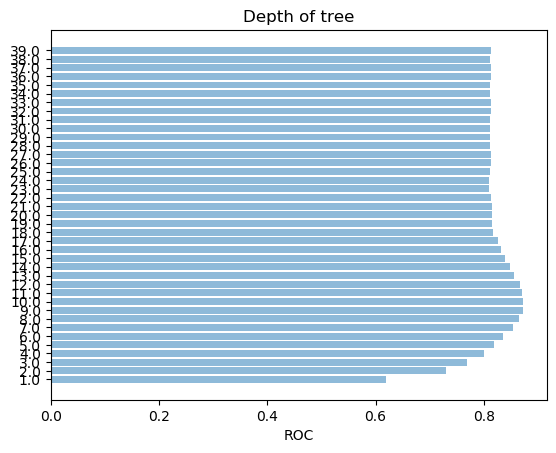

In [42]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ROC_Depths['depth']
y_pos = np.arange(len(ROC_Depths['depth']))
performance = ROC_Depths['ROC']

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('ROC')
plt.title('Depth of tree')

plt.show()

In [9]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(dec_tree.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
9,doctor_recc_h1n1,0.111
10,doctor_recc_seasonal,0.091
14,health_insurance,0.075
18,opinion_seas_vacc_effective,0.074
15,opinion_h1n1_vacc_effective,0.047
...,...,...
64,employment_industry_qnlwzans,0.000
51,census_msa_nan,0.000
48,hhs_geo_region_nan,0.000
29,race_nan,0.000


In [30]:
final_dec_tree = DecisionTreeClassifier(max_depth = 10)

final_dec_tree.fit(raw_df_processed_balanced, labels_df_balanced)
test_probability = final_dec_tree.predict_proba(test_df_processed)


y_preds = pd.DataFrame(
{
        "h1n1_vaccine": test_probability[0][:, 1],
        "seasonal_vaccine": test_probability[1][:, 1],
    },
    index = test_df_processed.index
    )

In [31]:
submission_df = pd.read_csv(data_path_raw / "submission_format.csv", 
                            index_col="respondent_id")

In [32]:
np.testing.assert_array_equal(test_df_processed.index.values, 
                              submission_df.index.values)

In [33]:
# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = y_preds["h1n1_vaccine"]
submission_df["seasonal_vaccine"] = y_preds["seasonal_vaccine"]

In [34]:
#CHANGE PATH 

output_path = Path.cwd().parent.parent / "models" / "submissions"

submission_df.to_csv(output_path /'DecTree_JFR_200805_ordinal_nominal_meanImpute_balanced.csv', index=True)
